##### Import the libraries

In [26]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
import pandas as pd
from torchvision.ops import nms
from tqdm import tqdm
from segmentation_models_pytorch import Unet
from torchvision.transforms.functional import pad
import torchvision.models as models

#### The model performance on the evalution dataset (test dataset)

##### load the deeplab3 model

In [27]:
# Load a pre-trained FCN model
model = models.segmentation.deeplabv3_resnet50(weights=True)

# Modify the classifier for 1 class (window vs. facade)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

c:\Users\mohamad\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# Define the path to load the model
# load_path = "fasterrcnn_checkpoint_batch_32.pth"
load_path = os.path.join("trained_models", "deeplab_checkpoint.pth")

# Load the checkpoint
checkpoint = torch.load(load_path)

# Load the model state dictionary
model.load_state_dict(checkpoint)

print(f"Model loaded from {load_path}")

Model loaded from trained_models\deeplab_checkpoint.pth


In [29]:
threshold = 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(DEVICE)

val_image_dir = "Evaluation_dataset"
val_masks_dir = os.path.join("Evaluation_dataset", "masks")

##### Evaluate the model

In [30]:
class FacadeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = []
        
        # Create a list of images that have corresponding masks
        for file in os.listdir(image_dir):
            if file.endswith('.jpg'):
                mask_name = f"mask_{os.path.splitext(file)[0]}.png"
                mask_path = os.path.join(mask_dir, mask_name)
                if os.path.exists(mask_path):
                    self.images.append(file)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = f"mask_{os.path.splitext(img_name)[0]}.png"
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Compute padding
        original_width, original_height = image.size
        new_width = (original_width + 31) // 32 * 32
        new_height = (original_height + 31) // 32 * 32
        padding_left = (new_width - original_width) // 2
        padding_top = (new_height - original_height) // 2
        padding_right = new_width - original_width - padding_left
        padding_bottom = new_height - original_height - padding_top

        # Pad the image and mask
        image = pad(image, (padding_left, padding_top, padding_right, padding_bottom))
        mask = pad(mask, (padding_left, padding_top, padding_right, padding_bottom))

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [31]:
# Define transformations
transform = transforms.Compose([
    # transforms.Resize((image_new_dimension, image_new_dimension)),
    transforms.ToTensor()
])

val_dataset = FacadeDataset(val_image_dir, val_masks_dir, transform = transform)
print(f"Total images with annotations: {len(val_dataset)}")

Total images with annotations: 477


In [32]:
val_loader = DataLoader(val_dataset, shuffle=False)

In [33]:
# # Metric Evaluation
# model.eval()
# with torch.no_grad():
#     val_loader_tqdm = tqdm(val_loader, desc="Validating Metrics", leave=False)
#     all_precisions, all_recalls, all_f1s, all_ious = [], [], [], []
#     for _, (images, masks) in enumerate(val_loader_tqdm):

#         images = images.to(DEVICE)
#         masks = masks.to(DEVICE)
        
#         # Get predictions
#         outputs = model(images)['out']

#         preds = torch.sigmoid(outputs) > threshold  # Threshold predictions at 0.5

#         # Flatten predictions and masks for metric calculation
#         preds_flat = preds.view(-1)
#         masks_flat = masks.view(-1).bool()
        
#         # Calculate precision, recall, F1 at IoU 0.5 threshold
#         # Precision, Recall, F1-Score
#         tp = (preds_flat & masks_flat).sum().item()
#         fp = (preds_flat & ~masks_flat).sum().item()
#         fn = (~preds_flat & masks_flat).sum().item()
                
#         iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
#         precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#         recall = tp / (tp + fn) if (tp + fn) > 0 else 0
#         f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
#         all_ious.append(iou)
#         all_precisions.append(precision)
#         all_recalls.append(recall)
#         all_f1s.append(f1)

#     # Calculate mean metrics over the entire validation set
#     mean_iou = sum(all_ious) / len(all_ious) if all_ious else 0
#     mean_precision = sum(all_precisions) / len(all_precisions) if all_precisions else 0
#     mean_recall = sum(all_recalls) / len(all_recalls) if all_recalls else 0
#     mean_f1 = sum(all_f1s) / len(all_f1s) if all_f1s else 0

#     print(f"  Mean IoU: {mean_iou:.4f}")
#     print(f"  Precision: {mean_precision:.4f}")
#     print(f"  Recall: {mean_recall:.4f}")
#     print(f"  F1 Score: {mean_f1:.4f}")

#### WWR calculation

In [34]:
# Define the path to your image
file_name = "rectified_facade_DENW20AL0000qVme.jpg"

image_path = os.path.join("Evaluation_dataset", file_name)

In [35]:
# Load the JSON file
file_path = os.path.join("Evaluation_dataset", "merged.json")
with open(file_path, 'r') as f:
    data = json.load(f)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the correct device
model = model.to(device)

##### Facade area in meters

In [37]:
# Load the Excel file
file_path = "soest_duesseldorf_combined_valid_results_with_geometry_with_width.xlsx"
df = pd.read_excel(file_path, dtype=str)  # Read as strings to avoid type issues

# Extract the gmlid from the filename
gmlid = file_name.replace("rectified_facade_", "").replace(".jpg", "")

# Search for the corresponding row
row = df[df["gmlid"] == gmlid]

if not row.empty:
    # Retrieve relevant facade height and width
    facade_height_meters = float(row["relevant_facade_height"].values[0])
    facade_width_meters = float(row["relevant_facade_width"].values[0])

    # Compute facade area
    facade_area = facade_height_meters * facade_width_meters

    rich.print(f"GMLID: {gmlid}")
    rich.print(f"Facade Height: {facade_height_meters} meters")
    rich.print(f"Facade Width: {facade_width_meters} meters")
    rich.print(f"Facade Area: {facade_area} square meters")
else:
    rich.print(f"No matching GMLID found for {gmlid}.")

GMLID: DENW20AL0000qVme

Facade Height: 15.913 meters

Facade Width: 10.48529875589549 meters

Facade Area: 166.85255910256495 square meters

##### image area in pixels

In [38]:
# Step 1: Find the image details for the given file name
image_details = next(item for item in data["images"] if item["file_name"] == file_name)

# Extract width and height
image_height_pixels = image_details["height"]
image_width_pixels = image_details["width"]

rich.print(f"Image Height: {image_height_pixels} pixels")
rich.print(f"Image Width: {image_width_pixels} pixels")

# Calculate the image area
image_area_pixels = image_height_pixels * image_width_pixels

# rich.print(f"Image dimensions for '{file_name}': {image_width}x{image_height}")
rich.print(f"Total image area for '{file_name}': {image_area_pixels} pixels²")

Image Height: 468 pixels

Image Width: 314 pixels

Total image area for 'rectified_facade_DENW20AL0000qVme.jpg': 146952 pixels²

##### Pixel size in square meters

In [39]:
# Calculate the pixel size in square meters
pixel_size_meters = (facade_width_meters / image_width_pixels) * (
        facade_height_meters / image_height_pixels)

rich.print("pixel size in meters", pixel_size_meters)

pixel size in meters 0.0011354221725635918

##### Ground truth area

In [40]:
image_id = next(item["id"] for item in data["images"] if item["file_name"] == file_name)

# Step 2: Filter annotations for the image_id and category "window" (category_id = 1)
window_annotations = [
    annotation for annotation in data["annotations"]
    if annotation["image_id"] == image_id and annotation["category_id"] == 1
]

# Step 3: Calculate total area and count
windows_area_gt = sum(ann["area"] for ann in window_annotations)
num_windows = len(window_annotations)

# rich.print(f"Number of windows: {num_windows}")
rich.print(f"Total window area for '{file_name}': {windows_area_gt} pixels²")

Total window area for 'rectified_facade_DENW20AL0000qVme.jpg': 34945.82000000001 pixels²

##### Calculate the predicted area

In [41]:
# Load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to tensor
    ])
    return transform(image)

In [42]:
input_image = load_image(image_path).unsqueeze(0).to(device)  # Add batch dimension and move to deviceu

# Run the model
model.eval()
with torch.no_grad():
    output = model(input_image)['out']  # FCN outputs a dictionary with key 'out'

# Post-process the output to binary segmentation map
segmentation_map = torch.sigmoid(output).squeeze().cpu().numpy()  # Apply sigmoid activation and remove batch dim

# Apply a threshold to obtain binary mask (window vs non-window)
threshold = 0.5
binary_mask = (segmentation_map > threshold).astype(float)

# Calculate the total area of predicted windows
windows_area_p = binary_mask.sum()  # Count pixels in the mask

# Print the total windows area
rich.print(f"Total predicted windows area for '{file_name}': {windows_area_p} pixels²")

Total predicted windows area for 'rectified_facade_DENW20AL0000qVme.jpg': 13442.0 pixels²

##### WWR actual and predicted in pixels

In [43]:
# Calculate ground truth WWR
wwr_gt = windows_area_gt / image_area_pixels if image_area_pixels > 0 else 0

rich.print(f"Window-to-Wall Ratio (ground truth) (WWR) for '{file_name}': {wwr_gt:.4f}")

# Calculate predicted WWR
wwr_P = windows_area_p / image_area_pixels if image_area_pixels > 0 else 0

rich.print(f"Window-to-Wall Ratio (predcited) (WWR) for '{file_name}': {wwr_P:.4f}")

# Calculate the absolute difference
wwr_difference = abs(wwr_gt - wwr_P)

# Optionally, calculate percentage difference
wwr_percentage_diff = (wwr_difference / wwr_gt * 100) if wwr_gt > 0 else 0

# Print the results
# rich.print(f"[bold]Difference between ground truth and predicted WWR:[/bold] {wwr_difference:.4f}")
# rich.print(f"[bold]Percentage difference:[/bold] {wwr_percentage_diff:.2f}%")

Window-to-Wall Ratio (ground truth) (WWR) for 'rectified_facade_DENW20AL0000qVme.jpg': 0.2378

Window-to-Wall Ratio (predcited) (WWR) for 'rectified_facade_DENW20AL0000qVme.jpg': 0.0915

##### WWR actual in meters

In [44]:
facade_meters = image_area_pixels * pixel_size_meters

rich.print(f"facade in meters {facade_meters} meters²")

facade in meters 166.85255910256492 meters²

In [45]:
window_meters_GT = windows_area_gt * pixel_size_meters

rich.print(f"windows in meters ground trught {window_meters_GT} meters²")

windows in meters ground trught 39.67825886641622 meters²

In [46]:
WWR_GT_actual = window_meters_GT / facade_meters

rich.print(f"WWR Ground trugth {WWR_GT_actual}")

WWR Ground trugth 0.23780431705590946

##### WWR predicted in meters

In [47]:
window_meters_P = windows_area_p * pixel_size_meters

rich.print(f"windows in meters predcited {window_meters_P} meters²")

windows in meters predcited 15.2623448435998 meters²

In [48]:
WWR_p_actual = window_meters_P / facade_meters

rich.print(f"WWR predicted {WWR_p_actual}")

WWR predicted 0.09147204529370136

#### Visualizing the results (u_net) on the Evalution subset

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

def visualize_segmentation(prediction_mask, image_tensor, threshold=0.5, class_names=None):
    """
    Visualizes the segmentation predictions on an image.

    Args:
        prediction_mask (np.array): Binary segmentation mask (H, W).
        image_tensor (Tensor): Original image tensor.
        threshold (float): Threshold applied to prediction probabilities.
        class_names (list): Optional list of class names, where index corresponds to class label.
    """
    # Convert the tensor to a PIL image for visualization
    img = transforms.ToPILImage()(image_tensor.cpu())

    # Create a figure
    plt.figure(figsize=(10, 10))

    # Show the original image
    plt.imshow(img, alpha=1.0)

    # Overlay the segmentation mask
    masked_image = np.ma.masked_where(prediction_mask == 0, prediction_mask)
    plt.imshow(masked_image, cmap='Reds', alpha=0.5, vmin=0, vmax=1)

    '''
    # Add a colorbar
    if class_names:
        cbar = plt.colorbar(ticks=range(len(class_names)))
        cbar.ax.set_yticklabels(class_names)
        '''

    plt.axis('off')
    # plt.title("Predicted Segmentation")
    plt.show()


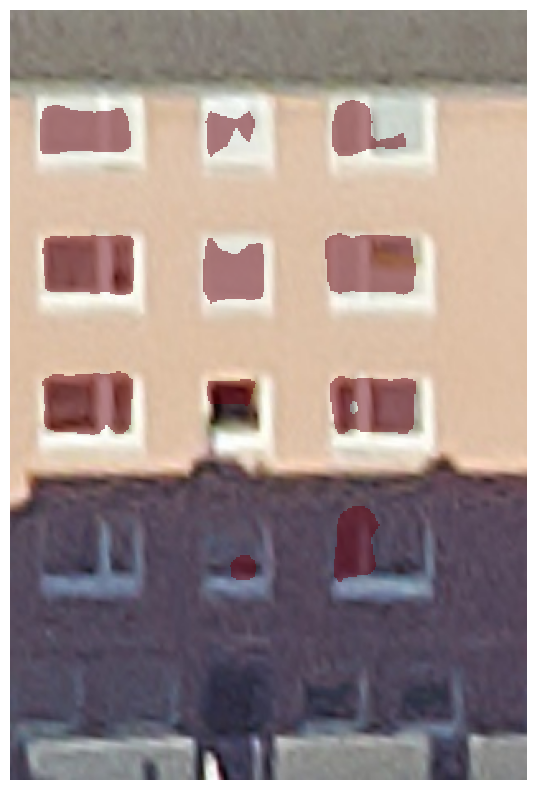

In [50]:
# Load the image
input_image = load_image(image_path).unsqueeze(0)  # Add a batch dimension
input_image = input_image.to(device)

# Run the model on the image
model.eval()
# Process the model output
with torch.no_grad():
    output = model(input_image)['out']  # U-Net output does not use ['out']

# Apply sigmoid to get probabilities
segmentation_map = torch.sigmoid(output).squeeze().cpu().numpy()

# Apply threshold to generate a binary mask
threshold = threshold
binary_mask = (segmentation_map > threshold).astype(np.uint8)

# Visualize the segmentation predictions
class_names = ["background", "window"]  # Adjust based on your classes
visualize_segmentation(binary_mask, input_image[0], threshold=threshold, class_names=class_names)
